# NYC Taxi Trip Duration

In [5]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pickle
import os
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import GammaRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [9]:
#os.chdir('/Users/amelievogel/Desktop/data_science/Git\ -\ GitHub/prediction-nyc-trip-duration/data')

In [8]:
# Loading and reading the data
trip_duration_df = pd.read_csv('data/taxi_trip.csv')

In [4]:
trip_duration_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


# Pre-cleaning of the raw data

In [5]:
# Changing the data type of the two features pickup_datetime and dropoff_datetime to datetime data
trip_duration_df.pickup_datetime = pd.to_datetime(trip_duration_df.pickup_datetime)
trip_duration_df.dropoff_datetime = pd.to_datetime(trip_duration_df.dropoff_datetime)

In [6]:
# Exatracting from the datetime feature (pickup_datetime) the month, the day of the year, the day of the week and the hour of the day
# Month of year
trip_duration_df['myear'] = trip_duration_df.pickup_datetime.dt.month
# Day of week
trip_duration_df['dweek'] = trip_duration_df.pickup_datetime.dt.weekday
# Day of year
trip_duration_df['dyear'] = trip_duration_df.pickup_datetime.dt.dayofyear
# Hour of the day 
trip_duration_df['hday'] = trip_duration_df.pickup_datetime.dt.hour


In [7]:
# Transforming hours of day into categorical data: morning, afternoon, evening and night
trip_duration_df['Moment_of_day'] = trip_duration_df.hday.apply(lambda x: 'Night' if x <= 6 and x > 0
               else 'Morning' if x > 6 and x <= 12
               else 'Afternoon' if x > 12 and x <= 18
               else 'Evening')

This dataset only contains the first 6 months of the year 2016.

# Cleaning of the weather data

In [8]:
weather_df = pd.read_csv('weather.csv')

## Date

In [9]:
# Transform the feature date to datetime
weather_df.date = pd.to_datetime(weather_df.date, dayfirst=True)
# Extract the day of teh year from the date
# Day of year
weather_df['dyear'] = weather_df.date.dt.dayofyear

## Precipitation

Weather measurements made at Central Park indicate that it rained 42.2 inches of water in NYC in 2016:

https://www.currentresults.com/Yearly-Weather/USA/NY/New-York-City/recent-annual-new-york-city-temperature-precipitation.php

In [10]:
weather_df.loc[weather_df.precipitation != 'T'].precipitation.astype(float).sum()

42.17

Precipitations (with 'T' entries excluded) sum up to 42.17 which is extremely close to the above mentioned number of 42.2
This suggests that we can assume 'T' entries ('traces') to be 0.

In [11]:
weather_df.loc[weather_df['precipitation'] == 'T', 'precipitation'] = 0
weather_df.precipitation = weather_df.precipitation.astype(float)

As per Wikipedia:
https://en.wikipedia.org/wiki/Rain#:~:text=The%20following%20categories%20are%20used%20to%20classify%20rainfall%20intensity%3A&text=Moderate%20rain%20%E2%80%94%20when%20the%20precipitation,mm%20(2.0%20in)%20per%20hour
The following categories are used to classify rainfall intensity:

Light rain — when the precipitation rate is < 2.5 mm (0.098 in) per hour
Moderate rain — when the precipitation rate is between 2.5 mm (0.098 in) - 7.6 mm (0.30 in) or 10 mm (0.39 in) per hour
Heavy rain — when the precipitation rate is > 7.6 mm (0.30 in) per hour,[106] or between 10 mm (0.39 in) and 50 mm (2.0 in) per hour
Violent rain — when the precipitation rate is > 50 mm (2.0 in) per hour

In [12]:
weather_df['prec_hourly_avg'] = weather_df.precipitation/4
# 4 accounts for the fact that when it rains, it does not necessarily rain for the entire day
# here we assume that when it rains, it rains 4 hours a day

weather_df['prec_intensity'] = weather_df.prec_hourly_avg.apply(lambda x: 'L' if x < 0.098
                                                          else 'M' if x >= 0.098 and x < 0.3
                                                          else 'H' if x >= 0.3 and x <= 2
                                                          else 'V')
weather_df.drop('prec_hourly_avg', axis=1, inplace=True)
weather_df

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,dyear,prec_intensity
0,2016-01-01,42,34,38.0,0.00,0.0,0,1,L
1,2016-01-02,40,32,36.0,0.00,0.0,0,2,L
2,2016-01-03,45,35,40.0,0.00,0.0,0,3,L
3,2016-01-04,36,14,25.0,0.00,0.0,0,4,L
4,2016-01-05,29,11,20.0,0.00,0.0,0,5,L
...,...,...,...,...,...,...,...,...,...
361,2016-12-27,60,40,50.0,0.00,0,0,362,L
362,2016-12-28,40,34,37.0,0.00,0,0,363,L
363,2016-12-29,46,33,39.5,0.39,0,0,364,L
364,2016-12-30,40,33,36.5,0.01,T,0,365,L


## Snow

Weather measurements made at Central Park indicate that it snowed 36.0 inches in NYC in 2016:

https://www.currentresults.com/Yearly-Weather/USA/NY/New-York-City/recent-annual-new-york-city-temperature-precipitation.php

In [13]:
weather_df.loc[weather_df['snow fall'] != 'T']['snow fall'].astype(float).sum()

36.0

Snow (with 'T' entries excluded) sums up to 36.0 inches which is the same as the above mentioned number.
We can safely assume that 'T' entries stand for 0 snow.

In [14]:
weather_df.loc[weather_df['snow fall'] == 'T', 'snow fall'] = 0
weather_df['snow fall'] = weather_df['snow fall'].astype(float)

# let us simply assume that, just like for precipitation and snow fall, snow depth = 'T' means 0
weather_df.loc[weather_df['snow depth'] == 'T', 'snow depth'] = 0
weather_df['snow depth'] = weather_df['snow depth'].astype(float)

In [15]:
weather_df.drop(['maximum temperature','minimum temperature'], axis=1, inplace=True)

# Merge datasets: weather with train

In [16]:
df = trip_duration_df.merge(weather_df, how='left', on='dyear')

# Cleaning of the main data in df

In [17]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dweek,dyear,hday,Moment_of_day,date,average temperature,precipitation,snow fall,snow depth,prec_intensity
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0,74,17,Afternoon,2016-03-14,45.5,0.29,0.0,0.0,L
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6,164,0,Evening,2016-06-12,72.5,0.00,0.0,0.0,L
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,1,19,11,Morning,2016-01-19,22.0,0.00,0.0,0.0,L
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2,97,19,Evening,2016-04-06,39.0,0.00,0.0,0.0,L
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5,86,13,Afternoon,2016-03-26,46.5,0.00,0.0,0.0,L


In [18]:
# Dropping pointless features
df.drop(['vendor_id', 'store_and_fwd_flag', 'date'], axis=1, inplace=True)

In [19]:
# Dropping rows where there is no passenger
list(df.passenger_count[df.passenger_count==0].index)
df.drop(list(df.passenger_count[df.passenger_count==0].index), inplace=True)

In [20]:
# Removing outliers: trips shorter than a minute as well as the trips longer than 2 hours. See boxplots in Exploration.
df = df.loc[df.trip_duration.between(60, 7200)].reset_index(drop=True)

In [21]:
df['workday_weekend'] = df.dweek.apply(lambda x: 0 if x == 5 or x == 6
                                     else 1)

## Distance in km

#### Calculate the distance in km thanks to the coordinates of pickup and dropoff

https://www.kite.com/python/answers/how-to-find-the-distance-between-two-lat-long-coordinates-in-python

The Haversine formula calculates the great-circle distance between two points. Start by calculating the change in latitude and longitude, in radians, and input the result into the Haversine formula (implemented below). Use the functions in the math library for trigonometry related calculations.

R = 6373.0
radius of the Earth


lat1 = math.radians(52.2296756)
coordinates

lon1 = math.radians(21.0122287)
lat2 = math.radians(52.406374)
lon2 = math.radians(16.9251681)

dlon = lon2 - lon1
change in coordinates

dlat = lat2 - lat1

a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
Haversine formula

c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
distance = R * c

print(distance)

In [22]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees).

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km

In [23]:
# Calculating the distance
df['distance_KM'] = haversine_np(np.array(df['pickup_longitude']), 
                                  np.array(df['pickup_latitude']), 
                                  np.array(df['dropoff_longitude']), 
                                  np.array(df['dropoff_latitude']))

In [24]:
# Suppressing the rows where the distance is equal to 0
df.drop(list(df.loc[df.distance_KM==0].index), axis=0, inplace=True)

In [25]:
df_copy = df.copy()

# Exploration 

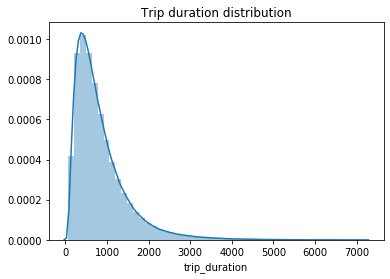

In [27]:
sns.distplot(df.trip_duration)
plt.title('Trip duration distribution')
plt.show()

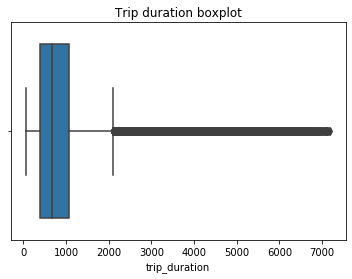

The mean of trip_duration in NYC is around 14.0 minutes, and the median is 11.1 minutes.


In [28]:
sns.boxplot(df.trip_duration)
plt.title('Trip duration boxplot')
plt.show()

mean_trip_duration = df.trip_duration.mean()/60
median_trip_duration = df.trip_duration.median()/60

print('The mean of trip_duration in NYC is around', round(mean_trip_duration, 1), 'minutes, and the median is', round(median_trip_duration, 1), 'minutes.')

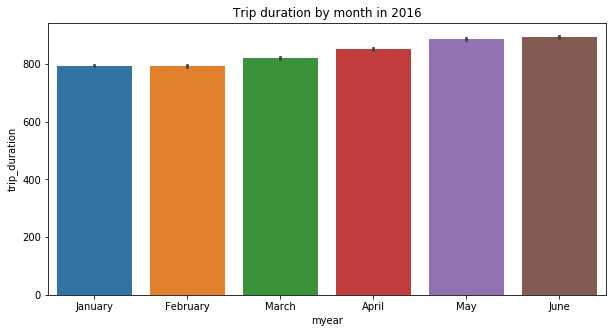

In [29]:
y = df.trip_duration
x = df.myear
plt.figure(figsize=(10,5))
g = sns.barplot(x, y)
g.set(xticklabels=['January', 'February', 'March', 'April', 'May', 'June'])
plt.title('Trip duration by month in 2016')
plt.show()

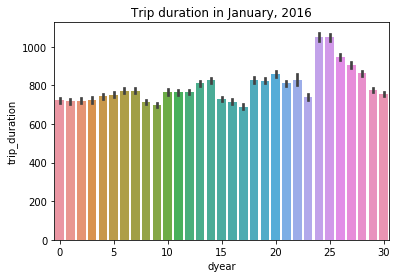

In [30]:
y = df.trip_duration
x = df[df.myear==1].dyear
sns.barplot(x, y)
ax = plt.gca(); ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d')) 
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=5)) 
plt.title('Trip duration in January, 2016')
plt.show()

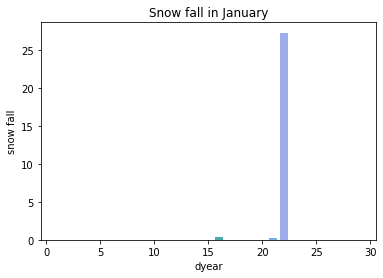

This plot shows that there has been a snowfall just a couple of days before the 24st of January, 
which could explain the increase in trip duration.


In [31]:
# Let's investigate on the 24, 25 and 26st of January (peaks in duration) with the weather data 
y = weather_df['snow fall']
x = weather_df[weather_df.dyear <= 31].dyear
sns.barplot(x, y)
ax = plt.gca(); ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d')) 
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=5)) 
plt.title('Snow fall in January')
plt.show()
print('This plot shows that there has been a snowfall just a couple of days before the 24st of January, \nwhich could explain the increase in trip duration.')

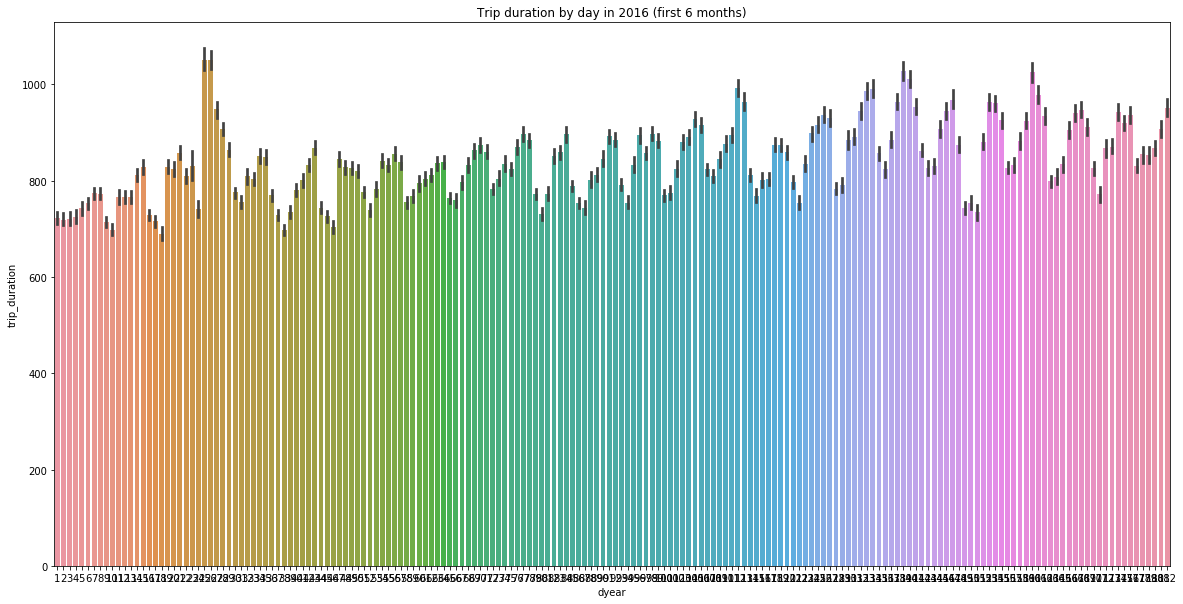

In [32]:
y = df.trip_duration
x = df.dyear
plt.figure(figsize=(20,10))
sns.barplot(x, y)
plt.title('Trip duration by day in 2016 (first 6 months)')
plt.show()

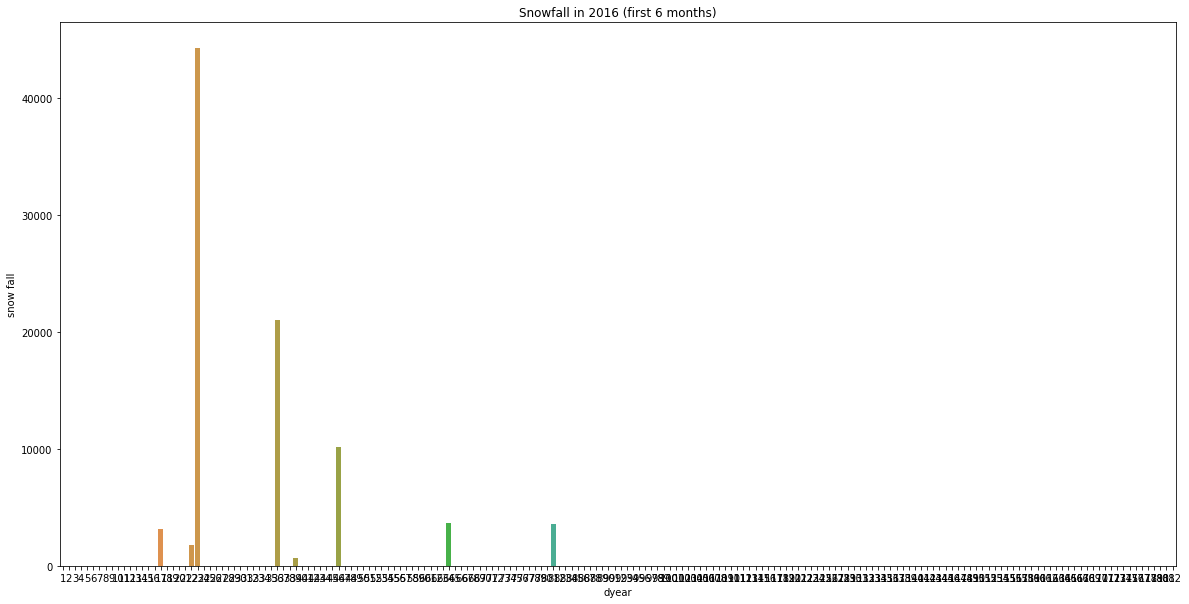

In [33]:
# Let's investigate the snowfall data, to check if there is an explanation of the variations in the trip durations
snow_df = df[['dyear', 'snow fall']].groupby('dyear').sum()
x = snow_df.index
y = snow_df['snow fall']
plt.figure(figsize=(20,10))
sns.barplot(x, y)
plt.title('Snowfall in 2016 (first 6 months)')
plt.show()

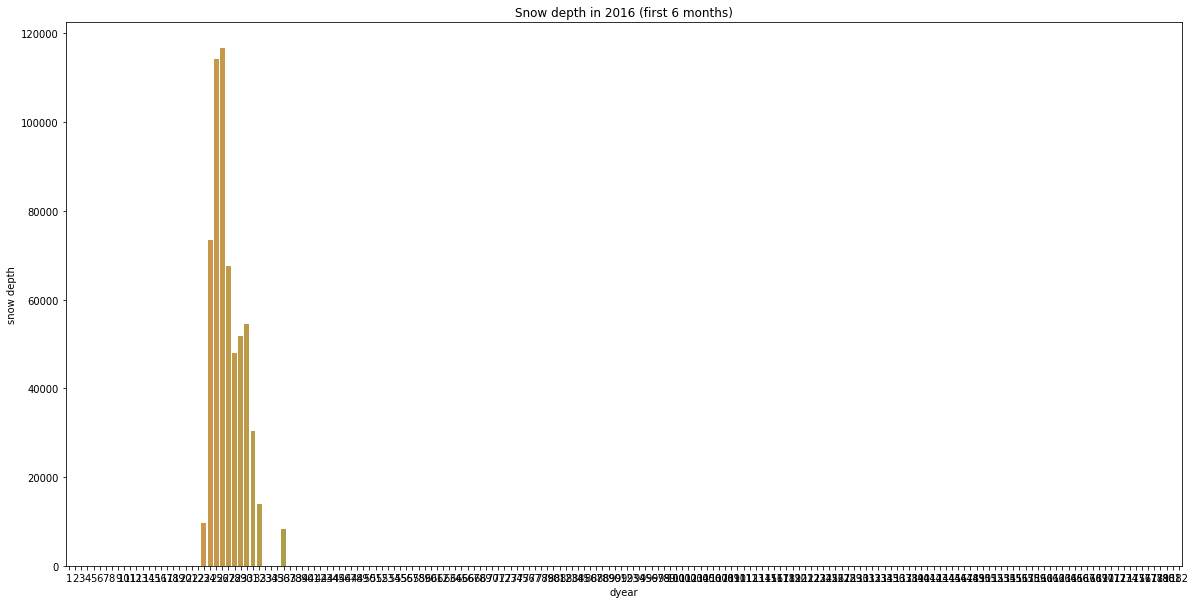

In [34]:
# Let's investigate the snow depth data, to check if there is an explanation of the variations in the trip durations
snow_df = df[['dyear', 'snow depth']].groupby('dyear').sum()
x = snow_df.index
y = snow_df['snow depth']
plt.figure(figsize=(20,10))
sns.barplot(x, y)
plt.title('Snow depth in 2016 (first 6 months)')
plt.show()

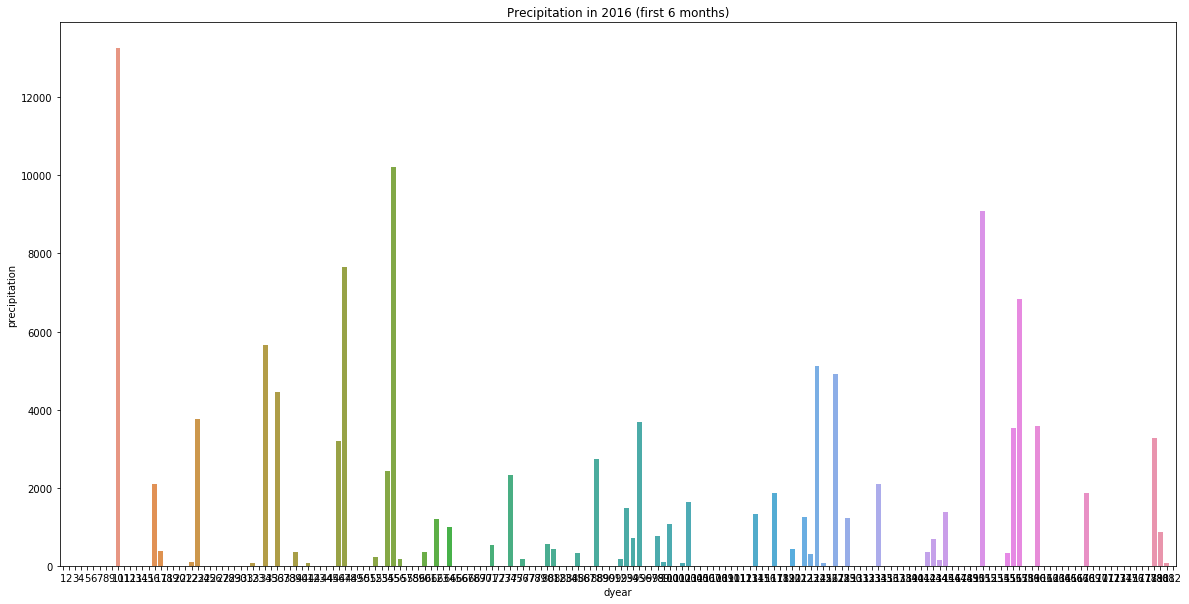

In [35]:
# Let's investigate the precipitation data, to check if there is an explanation of the variations in the trip durations
prec_df = df[['dyear', 'precipitation']].groupby('dyear').sum()
x = prec_df.index
y = prec_df['precipitation']
plt.figure(figsize=(20,10))
sns.barplot(x, y)
plt.title('Precipitation in 2016 (first 6 months)')
plt.show()

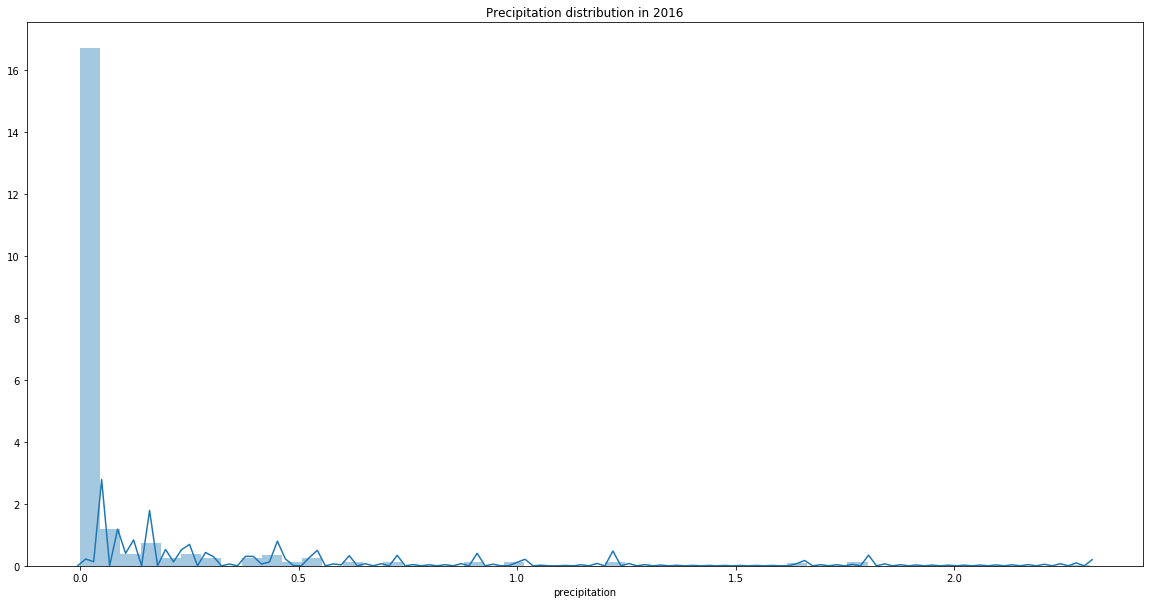

In [36]:
plt.figure(figsize=(20,10))
sns.distplot(df.precipitation)
plt.title('Precipitation distribution in 2016')
plt.show()

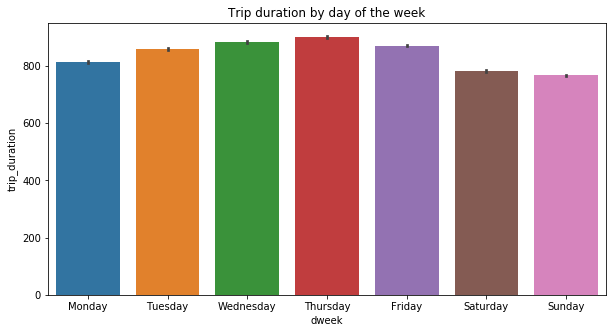

In [37]:
y = df.trip_duration
x = df.dweek
plt.figure(figsize=(10,5))
g = sns.barplot(x, y)
g.set(xticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Trip duration by day of the week')
plt.show()

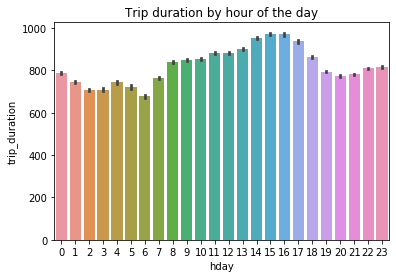

In [38]:
y = df.trip_duration
x = df.hday
sns.barplot(x, y)
plt.title('Trip duration by hour of the day')
plt.show()

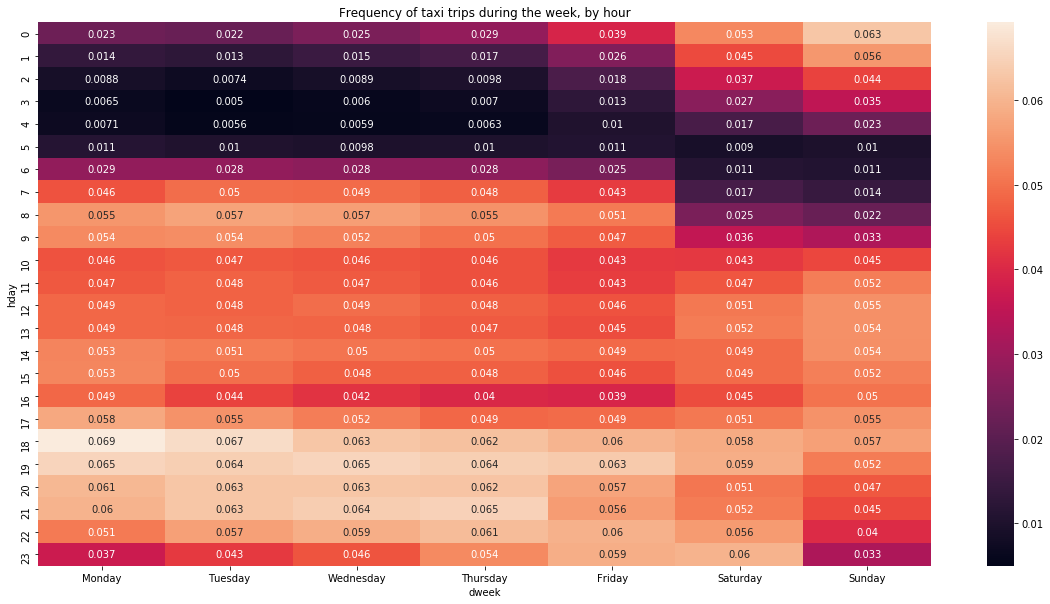

In [39]:
# Distribution of the trips during the week
plt.subplots(figsize=(20,10))
g = sns.heatmap(pd.crosstab(df.hday,df.dweek,normalize='columns'),annot=True)
plt.title('Frequency of taxi trips during the week, by hour')
g.set(xticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

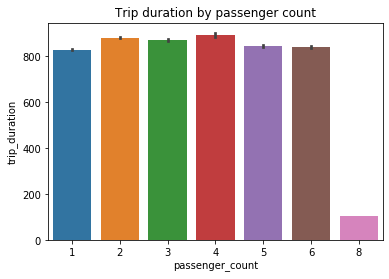

In [40]:
y = df.trip_duration
x = df.passenger_count
sns.barplot(x, y)
plt.title('Trip duration by passenger count')
plt.show()

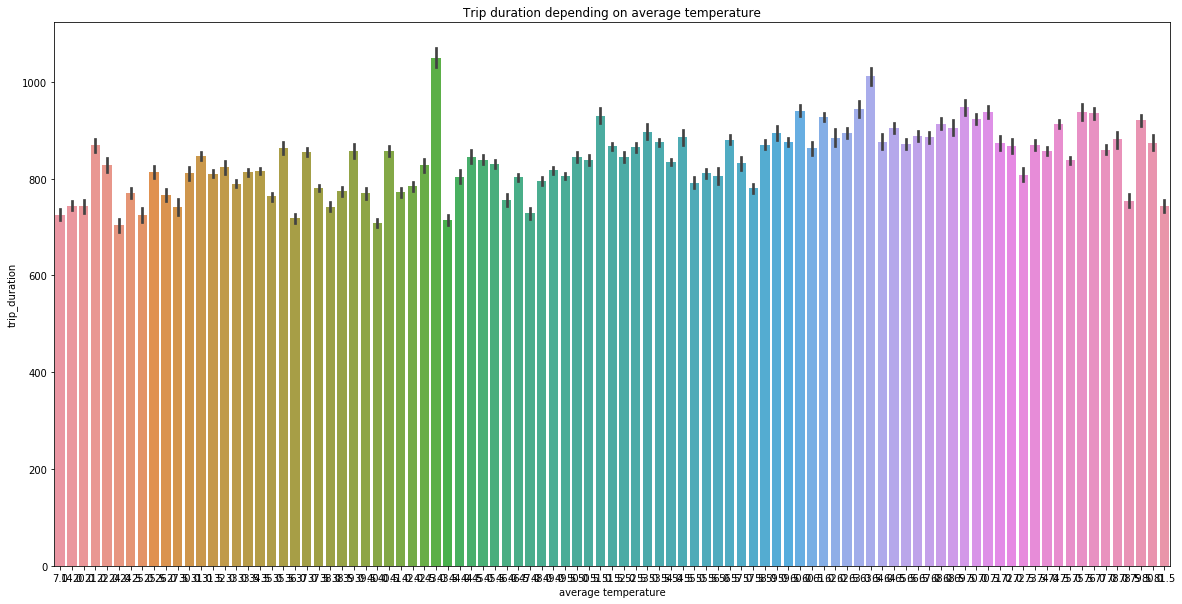

The average temperature during the six first months of the year is comprised between (7.0, 81.5)


In [41]:
min_max = (df['average temperature'].min(), df['average temperature'].max())

plt.subplots(figsize=(20,10))
y = df.trip_duration
x = df['average temperature']
sns.barplot(x, y)
plt.title('Trip duration depending on average temperature')
plt.show()
print(f'The average temperature during the six first months of the year is comprised between {min_max}')                                                                                            

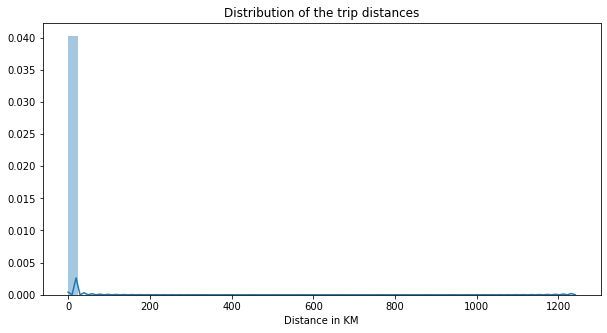

In [42]:
plt.figure(figsize=(10,5))
sns.distplot(df.distance_KM)
plt.title('Distribution of the trip distances')
plt.xlabel('Distance in KM')
plt.show()

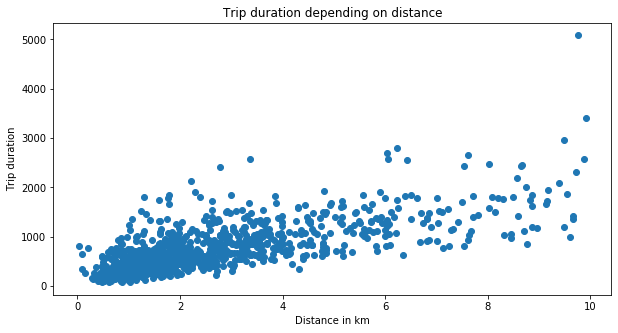

In [43]:
x = df.loc[df.distance_KM<10].distance_KM[201000:202000]
y = df.loc[df.distance_KM<10].trip_duration[201000:202000]
plt.figure(figsize=(10,5))
plt.scatter(x, y)
plt.xlabel('Distance in km')
plt.ylabel('Trip duration')
plt.title('Trip duration depending on distance')
plt.show()

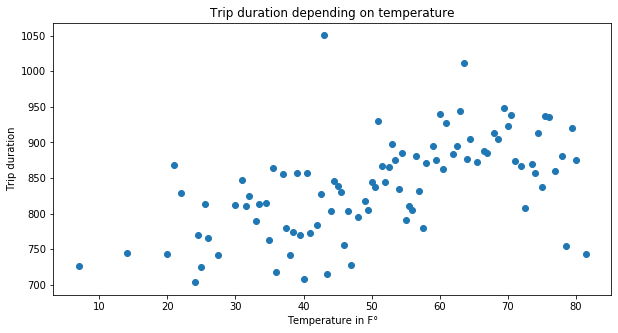

In [44]:
aver_trip_temp = df[['trip_duration']].groupby(df['average temperature']).mean()

x = aver_trip_temp.index
y = aver_trip_temp.trip_duration
plt.figure(figsize=(10,5))
plt.scatter(x, y)
plt.xlabel('Temperature in F°')
plt.ylabel('Trip duration')
plt.title('Trip duration depending on temperature')
plt.show()

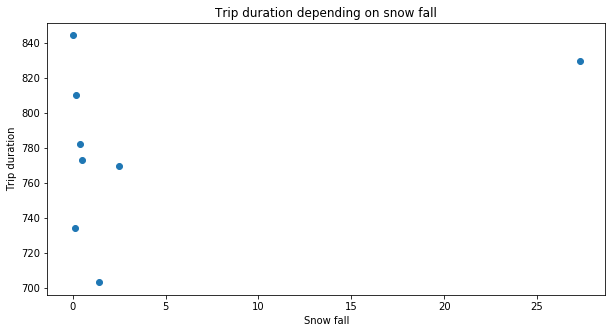

In [45]:
aver_trip_snow_fall = df[['trip_duration']].groupby(df['snow fall']).mean()

x = aver_trip_snow_fall.index
y = aver_trip_snow_fall.trip_duration
plt.figure(figsize=(10,5))
plt.scatter(x, y)
plt.xlabel('Snow fall')
plt.ylabel('Trip duration')
plt.title('Trip duration depending on snow fall')
plt.show()

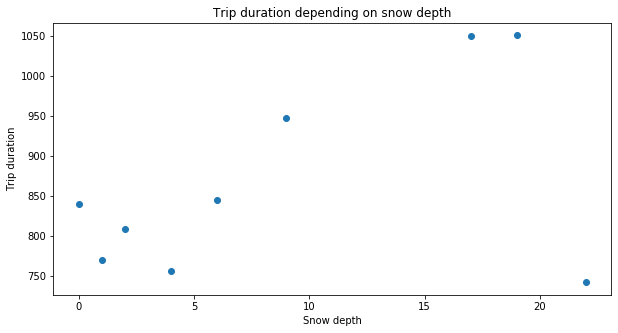

In [46]:
aver_trip_snow_depth = df[['trip_duration']].groupby(df['snow depth']).mean()

x = aver_trip_snow_depth.index
y = aver_trip_snow_depth.trip_duration
plt.figure(figsize=(10,5))
plt.scatter(x, y)
plt.xlabel('Snow depth')
plt.ylabel('Trip duration')
plt.title('Trip duration depending on snow depth')
plt.show()

# Modelling

## Pre-processing

In [40]:
# Checkpoint if needed:
df = df_copy.copy()

In [41]:
# Getting dummies:
dummies = ['myear', 'Moment_of_day']
df = pd.get_dummies(data=df, columns=dummies, drop_first=True)

# Dropping columns
df = df.drop(['id', 'pickup_datetime', 'dropoff_datetime', 
                      'dweek', 'prec_intensity', 'dyear', 'hday'], axis=1)

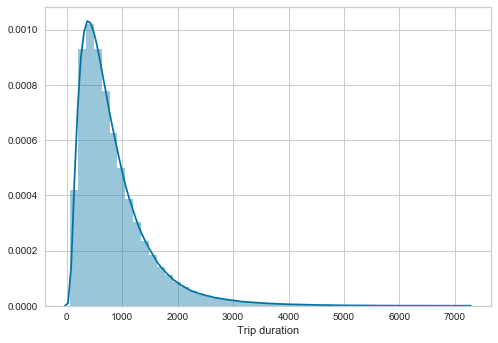

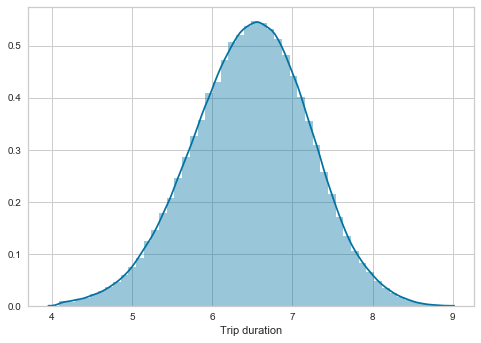

In [42]:
# Checking the distribution of the datapoints
sns.distplot(df['trip_duration'])
plt.xlabel('Trip duration')
plt.show()


# Normalizing the distribution of the datapoints
df['trip_duration_norm'] = np.log(df.trip_duration)


# Checking the distribution of the datapoints after normalization
sns.distplot(df['trip_duration_norm'])
plt.xlabel('Trip duration')
plt.show()

In [43]:
# Saving X and y columns into lists
cols = list(df.columns)
X_cols = cols
X_cols.remove('trip_duration')
X_cols.remove('trip_duration_norm')
y_cols = ['trip_duration_norm']

Since there might be multicolinearity problems, we retrieve these columns ['dweek', 'prec_intensity', 'dyear'] from our train dataset. (and other features that are not important)

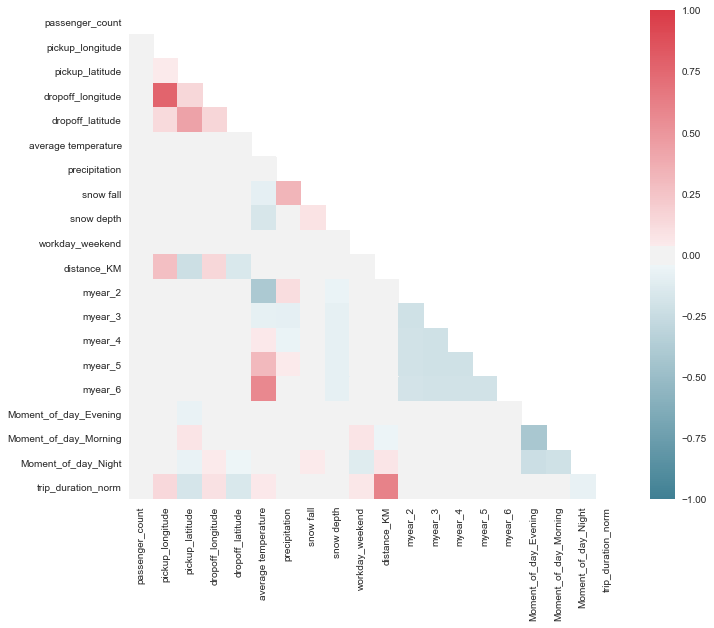

In [44]:
# Visualizing the heatmap and the correlated features
corr = df.drop(['trip_duration'], axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, cmap=cmap, center=0)
plt.show()

In [45]:
# Defining features and labels
X = df[X_cols]
y = df[y_cols]

# Splitting train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                       test_size = 1/3,  
                                       random_state = 23, 
                                       shuffle = True)

# Normalizing all features of X_train
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

## Feature engineering

In [46]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

### PCA

Let's run PCA in order to reduce/compress the data (nb of columns = 44) and make the clusters easy to visualize.

In [47]:
pca=PCA(0.8, random_state=44)
pca.fit(X_train)
pca.explained_variance_ratio_

array([0.19031983, 0.13692778, 0.12138723, 0.11179144, 0.11006415,
       0.10678359, 0.0933117 ])

In [48]:
pca_X_train = pca.transform(X_train)
pca_X_test = pca.transform(X_test)
pca_X_train

array([[-0.07653211, -0.17868837,  0.07840537, ...,  0.03063895,
         0.00376159,  0.36096388],
       [ 0.66213618, -0.38663212, -0.41393678, ...,  0.54906862,
        -0.58407359, -0.12950912],
       [ 0.66210833, -0.39067877, -0.44841507, ...,  0.54281601,
        -0.58093287, -0.12988759],
       ...,
       [-0.73288458, -0.28447021,  0.07331143, ...,  0.01031349,
        -0.03602834, -0.25103265],
       [ 0.00388442,  0.63059176, -0.67742576, ..., -0.16421769,
         0.74775604, -0.0114996 ],
       [-0.07581579, -0.17971419, -0.54026042, ...,  0.53011692,
        -0.5388355 ,  0.35562087]])

### Clustering - Elbow Method

Choosing the best number of clusters (k)

Without PCA (on original X_train):

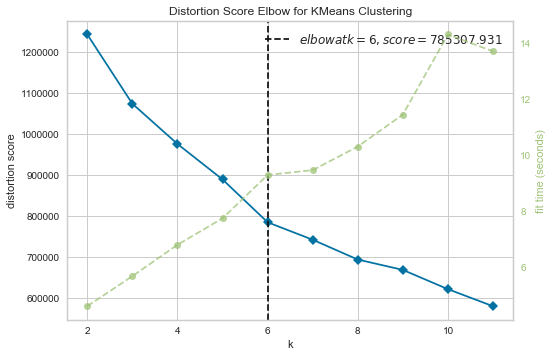

In [49]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(X_train)  # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [37]:
nb_clusters = visualizer.elbow_value_
print('According to the elbow method without PCA, we\'ll need', nb_clusters, 'clusters.')

According to the elbow method without PCA, we'll need 6 clusters.


With PCA (on new pca_X_train):

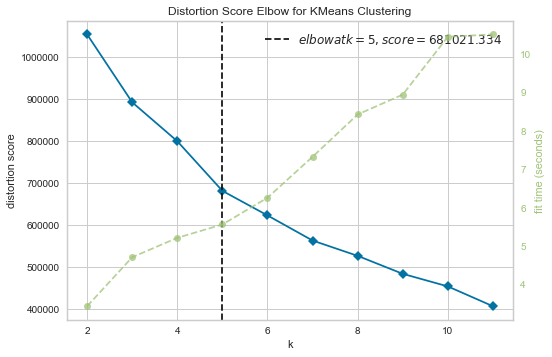

In [50]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(pca_X_train)  # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [51]:
nb_clusters_pca = visualizer.elbow_value_
print('According to the elbow method without PCA, we\'ll need', visualizer.elbow_value_, 'clusters.')

According to the elbow method without PCA, we'll need 5 clusters.


The elbow method with PCA doesn't prove to be much more efficient than without it. However, we'll run K-Means clustering with both nb_clusters and nb_clusters_pca, as a test. 

### K-Means Clustering

Let's first run K-means on pca_X_train, which comes from our PCA, with 5 clusters:

In [52]:
# Random initialization (for clusters centroids not to be stuck in local optima and get the best clusters)

kmeans_pca = KMeans(n_clusters=nb_clusters_pca, init = 'random', n_init = 100, random_state=42).fit(pca_X_train)
print(kmeans_pca.n_iter_)
print(kmeans_pca.labels_)
print(kmeans_pca.cluster_centers_)
print(kmeans_pca.inertia_)
# init = 'random' --> Randomly initialize by picking a random k, integer number < m (nb of rows)
# n_init = 100 --> Run k-means clustering and get the clusters + their centroids
# Compute cost-function J (distortion) of each model that has been run

6
[1 2 2 ... 1 3 2]
[[ 0.01886415  0.12998589  0.00937602 -0.64157457 -0.51752362 -0.30392622
   0.05114641]
 [-0.00341079  0.03350176  0.35243783 -0.13567493  0.28009234  0.18465579
   0.00231818]
 [-0.00145934  0.02187988 -0.46536559  0.13763199  0.53659874 -0.54245642
  -0.00089024]
 [-0.00678579 -0.13067381 -0.6272731   0.06172231 -0.15533188  0.67544641
  -0.03406731]
 [-0.00468598 -0.09063119  0.37335251  0.68885889 -0.38191154 -0.13048545
  -0.02246997]]
681021.3335573201


Let's now run K-Means on X_train with 6 clusters (without PCA):

In [53]:
kmeans = KMeans(n_clusters=nb_clusters, init = 'random', n_init = 100, random_state=42).fit(X_train)
print(kmeans.n_iter_)
print(kmeans.labels_)
print(kmeans.cluster_centers_)
print(kmeans.inertia_)
# Random initialization (for clusters centroids not to be stuck in local optima and get the best clusters):
# init = 'random' --> Randomly initialize by picking a random k, integer number < m (nb of rows)
# n_init = 100 --> Run k-means clustering and get the clusters + their centroids
# Compute cost-function J (distortion) of each model that has been run

10
[1 2 2 ... 4 0 2]
[[ 1.31415386e-01  8.72621740e-01  3.37473383e-01  9.06872580e-01
   6.37696432e-01  8.74913772e-01  3.79528108e-02 -1.80671450e-15
  -1.25593980e-14  7.37250669e-01  2.85964405e-03  8.11295475e-14
  -2.27040609e-14 -1.64701586e-13  3.18356452e-14  1.00000000e+00
   3.20501054e-01  2.77014362e-01  1.05788746e-01]
 [ 1.35776285e-01  8.72597261e-01  3.37402127e-01  9.06864123e-01
   6.37634848e-01  3.91186001e-01  5.11847809e-02  6.94129162e-03
   5.88208611e-02  6.87623356e-01  2.83649201e-03  5.06557559e-01
  -8.73190409e-14 -1.08524301e-13  3.28903571e-14  1.65145675e-14
   4.26651587e-01 -2.72282197e-13  1.41321269e-01]
 [ 1.32283177e-01  8.72618937e-01  3.37478002e-01  9.06872229e-01
   6.37714183e-01  7.41457129e-01  4.70540094e-02 -2.10465326e-15
  -1.31006317e-14  7.06862392e-01  2.88876436e-03  9.68947145e-14
  -3.44169138e-14 -1.80550019e-13  1.00000000e+00  8.84015083e-14
   3.15589585e-01  2.71764641e-01  1.06438103e-01]
 [ 1.32969311e-01  8.72604594e-01 

As said before, we'll keep the results of algorithms without PCA. 

Let's add the clusters as new features to X_train and X_test: X_train_df and X_test_df will be the new temporary sets:

In [54]:
X_train_df = pd.DataFrame(X_train, columns=list(X.columns))
X_train_df['clusters'] = kmeans.predict(X_train)
X_train_df.clusters = X_train_df.clusters.astype(str)
X_train_df = pd.get_dummies(data=X_train_df, columns=['clusters'], drop_first=True)

In [55]:
X_test_df = pd.DataFrame(X_test, columns=list(X.columns))
X_test_df['clusters'] = kmeans.predict(X_test_df)
X_test_df = pd.get_dummies(data=X_test_df, columns=['clusters'], drop_first=True)

In [59]:
# Build y_train_df and y_test_df: 
y_train_df = pd.DataFrame(y_train).reset_index(drop=True)
y_test_df = pd.DataFrame(y_test).reset_index(drop=True)

# Supervised Learning

### Linear Regression Model (with clusters as new features)

#### OLS with statsmodel

In [77]:
ols_model = sm.OLS(y_train_df, sm.add_constant(X_train_df))
results = ols_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      0   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                 3.209e+04
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        12:27:15   Log-Likelihood:            -8.1592e+05
No. Observations:              962374   AIC:                         1.632e+06
Df Residuals:                  962353   BIC:                         1.632e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    13.18

#### LinearRegression with sklearn

In [90]:
lr_model = LinearRegression()
lr_model.fit(X_train_df, y_train_df)
lr_model.coef_

array([[ 2.80317454e-02, -7.90277604e+01, -2.44471973e+01,
         8.43495416e+01, -1.45510991e+01,  4.32247651e-02,
        -8.76454938e-02,  2.25135788e-01,  2.55810212e-01,
         9.31505569e-02,  1.24904974e+02,  3.47528607e-02,
        -4.94926237e+10,  4.69086634e+11, -2.14120978e+11,
         2.98745182e+11, -1.52616655e-01, -4.03238297e-02,
        -3.59005140e-01,  2.98745182e+11,  5.12866160e+11,
         3.48237806e+11,  2.98745182e+11, -1.70341451e+11]])

In [91]:
lr_model.score(X_train_df, y_train_df)

0.40012210617721045

In [92]:
lr_model.score(X_test_df, y_test_df)

0.41070683433186517

In [93]:
# Defining features and labels
X = df[X_cols]
y = df[y_cols]

# Splitting train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                       test_size = 1/3,  
                                       random_state = 23, 
                                       shuffle = True)

# Normalizing all features of X_train
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Linear Regression Model (no clusters)

#### LinearRegression

In [94]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_model.coef_

array([[ 2.79443676e-02, -7.90885171e+01, -2.44665886e+01,
         8.44047207e+01, -1.45477096e+01,  3.95068027e-02,
        -8.88538301e-02,  2.27023310e-01,  2.55235911e-01,
         9.31783935e-02,  1.24905838e+02,  3.47028870e-02,
         4.14857396e-02,  7.90659318e-02,  8.71376042e-02,
         9.23915768e-02, -1.52649421e-01, -4.46318773e-02,
        -3.58929561e-01]])

In [95]:
lr_model.score(X_train, y_train)

0.40010839674979515

In [96]:
lr_model.score(X_test, y_test)

0.41067308483575327

Since we achieve a very similar correlation coefficient with and without clusters, we decide not to use clusters as features, from now.

### Ridge Regression Model 

In [103]:
ridge_model = Ridge(alpha=1)
ridge_model.fit(X_train, y_train)
ridge_model.coef_

array([[ 2.86162565e-02, -1.30611981e+01, -1.79823937e+01,
         2.32764506e+01, -1.55316285e+01,  4.30437996e-02,
        -8.95219450e-02,  2.25008871e-01,  2.54915915e-01,
         9.16948465e-02,  1.12177439e+02,  3.51097938e-02,
         4.22901590e-02,  7.94736014e-02,  8.81445805e-02,
         9.24439903e-02, -1.45274528e-01, -4.80177249e-02,
        -3.30917208e-01]])

In [104]:
ridge_model.score(X_train, y_train)

0.3926573719186035

In [105]:
ridge_model.score(X_test, y_test)

0.408037242243522

### Lasso Regression Model 

In [106]:
lasso_model = Lasso(alpha=0.0001)
lasso_model.fit(X_train, y_train)
lasso_model.coef_

array([ 2.70180093e-02, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -1.22428905e+01,  4.29684127e-02, -6.97787252e-02,  1.21867819e-01,
        2.39920717e-01,  8.87619478e-02,  1.15290756e+02,  2.90635242e-02,
        3.68050789e-02,  7.34993974e-02,  8.14949308e-02,  8.62091727e-02,
       -1.36995512e-01, -4.77818874e-02, -3.15054937e-01])

In [107]:
lasso_model.score(X_train, y_train)

0.38649539957022183

In [108]:
lasso_model.score(X_test, y_test)

0.41450782891781524

### Random Forest Regression

In [110]:
y_train = np.reshape(np.array(y_train), y_train.shape[0], )
y_test = np.reshape(np.array(y_test), y_test.shape[0], )

In [112]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=0)
rf_model.fit(X_train, y_train)
rf_model.score(X_train, y_train)

0.5167095963898317

In [113]:
rf_model.score(X_test, y_test)

0.5153018833255754

# Model selection with K-fold cross-validation

In [70]:
X = df[X_cols]
y = df[y_cols]

In [71]:
# "i-fold" (k-fold) cross validation
#X = X.sample(frac=1).reset_index(drop=True)
#Y = y.sample(frac=1).reset_index(drop=True)

X = X.sample(frac=1)
y = y.loc[X.index]

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [72]:
n_folds = 3

# For RandomForestRegression
max_depths = [1, 2, 3, 4, 5, 6, 8, 10, 15, 20]
nb_estimators = [10, 20, 30, 50, 70, 100]
# For Lasso Regression
lasso_alphas = [0.000001, 0.000003, 0.00001, 0.00003, 0.0001, 0.0003, 0.001]
# For Ridge Regression
ridge_alphas = [0.01, 0.03, 0.07, 0.1, 0.3, 0.7, 1, 2, 3]
# For LinearRegression used with Ridge when alpha = 0
lr_alpha = [0]

params = lr_alpha

scores_X_train = {param: [] for param in params}
scores_X_test = {param: [] for param in params}

k_means = False

for i in range(n_folds):
    print(f'Fold number {i}')
    # Train/test split for this iteration of i-fold cross validation
    X_test = X.loc[X.index.isin(range(int(i*X.shape[0]/n_folds), int((i+1)*X.shape[0]/n_folds-1)))]
    X_train = X.loc[~X.index.isin(range(int(i*X.shape[0]/n_folds), int((i+1)*X.shape[0]/n_folds-1)))]
    y_test = y.loc[y.index.isin(range(int(i*y.shape[0]/n_folds), int((i+1)*y.shape[0]/n_folds-1)))]
    y_train = y.loc[~y.index.isin(range(int(i*y.shape[0]/n_folds), int((i+1)*y.shape[0]/n_folds-1)))]
    
    print(f'Fold number {i} | Normalizing X_train features')
    # Normalize all the features of X_train
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    if k_means:
        print(f'Fold number {i} | Running elbow method for k means clustering')
        # Instantiate the clustering model and visualizer
        model = KMeans()
        visualizer = KElbowVisualizer(model, k=(2,12))

        visualizer.fit(X_train)  # Fit the data to the visualizer
        best_k = visualizer.elbow_value_ # Capture elbow value/best k

        print(f'Fold number {i} | Running k means clustering with best k of {best_k}')
        # Run k means clustering with best k 
        kmeans = KMeans(n_clusters=best_k, init = 'random', n_init = 100, random_state=42).fit(X_train)

        # Add cluster column (fitted on X_train) to both X_train and X_test, and get dummies for next models
        X_train_df = pd.DataFrame(X_train, columns=list(X.columns))
        X_train_df['clusters'] = kmeans.predict(X_train)
        X_train_df.clusters = X_train_df.clusters.astype(str)
        X_train_df = pd.get_dummies(data=X_train_df, columns=['clusters'], drop_first=True)

        X_test_df = pd.DataFrame(X_test, columns=list(X.columns))
        X_test_df['clusters'] = kmeans.predict(X_test)
        X_test_df = pd.get_dummies(data=X_test_df, columns=['clusters'], drop_first=True)

        # X_train and X_test ready
        X_train = np.array(X_train_df)
        X_test = np.array(X_test_df)
     
    # Useful for Gamma Regressor and Random Forest:
    y_train = np.array(y_train).reshape((y_train.shape[0], ))
    y_test = np.array(y_test).reshape((y_test.shape[0], ))
    
    print(f'Fold number {i} | Fitting model with different values of the parameter')
    # Fit the chosen model on X_train
    for param in params:
        print(f'Fold number {i} | param = {param}')
        #model = RandomForestRegressor(n_estimators=param, max_depth=15, random_state=0)
        #model = Lasso(alpha=param)
        model = Ridge(alpha=param)
        model.fit(X_train, y_train)

        # Get the scores of the model Ridge on X_train and X_test
        X_train_score = model.score(X_train, y_train)
        X_test_score = model.score(X_test, y_test)
    
        # Stock the scores of each loop in lists:
        scores_X_train[param].append(X_train_score)
        scores_X_test[param].append(X_test_score)
    #print(f'Fold number {i} | Train scores: {scores_X_train}')
    #print(f'Fold number {i} | Test scores: {scores_X_test}')
scores_X_train_avg = {param: np.mean(scores_X_train[param]) for param in params}
scores_X_test_avg = {param: np.mean(scores_X_test[param]) for param in params}

Fold number 0
Fold number 0 | Normalizing X_train features
Fold number 0 | Fitting model with different values of the parameter
Fold number 0 | param = 0
Fold number 1
Fold number 1 | Normalizing X_train features
Fold number 1 | Fitting model with different values of the parameter
Fold number 1 | param = 0
Fold number 2
Fold number 2 | Normalizing X_train features
Fold number 2 | Fitting model with different values of the parameter
Fold number 2 | param = 0


In [63]:
# WARNING: Uncomment only if you want to save new scores!
#pickle.dump(ridge_scores_X_test_avg, open('history/ridge_scores_X_test_avg.pickle', 'wb'))

In [69]:
max_depths = [1, 2, 3, 4, 5, 6, 8, 10, 15, 20]
nb_estimators = [10, 20, 30, 50, 70, 100]
lasso_alphas = [0.000001, 0.000003, 0.00001, 0.00003, 0.0001, 0.0003, 0.001]
ridge_alphas = [0.01, 0.03, 0.07, 0.1, 0.3, 0.7, 1, 2, 3]
lr_alpha = [0]

In [62]:
lr_scores_X_train_avg = pickle.load(open('history/lr_scores_X_train_avg.pickle', 'rb'))
lr_scores_X_test_avg = pickle.load(open('history/lr_scores_X_test_avg.pickle', 'rb'))

rf_depth_scores_X_train_avg = pickle.load(open('history/rf_depth_scores_X_train_avg.pickle', 'rb'))
rf_depth_scores_X_test_avg = pickle.load(open('history/rf_depth_scores_X_test_avg.pickle', 'rb'))

rf_estimators_scores_X_train_avg = pickle.load(open('history/rf_estimators_scores_X_train_avg.pickle', 'rb'))
rf_estimators_scores_X_test_avg = pickle.load(open('history/rf_estimators_scores_X_test_avg.pickle', 'rb'))

lasso_scores_X_train_avg = pickle.load(open('history/lasso_scores_X_train_avg.pickle', 'rb'))
lasso_scores_X_test_avg = pickle.load(open('history/lasso_scores_X_test_avg.pickle', 'rb'))

ridge_scores_X_train_avg = pickle.load(open('history/ridge_scores_X_train_avg.pickle', 'rb'))
ridge_scores_X_test_avg = pickle.load(open('history/ridge_scores_X_test_avg.pickle', 'rb'))

In [114]:
# Results of LinearRegression cross-validated:

#lr_scores_X_train_avg = scores_X_train_avg
#lr_scores_X_test_avg = scores_X_test_avg

print('Score of R-squared on the train set is', round(list(lr_scores_X_train_avg.values())[0], 2))
print('Score of R-squared on the test set is', round(list(lr_scores_X_test_avg.values())[0], 2))

Score of R-squared on the train set is 0.41
Score of R-squared on the test set is 0.39


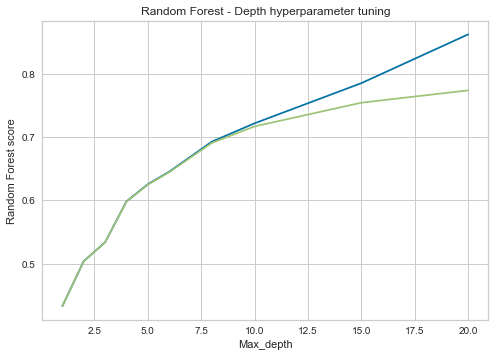

In [116]:
#rf_depth_scores_X_train_avg = scores_X_train_avg
#rf_depth_scores_X_test_avg = scores_X_test_avg
plt.plot(max_depths, list(rf_depth_scores_X_train_avg.values()))
plt.plot(max_depths, list(rf_depth_scores_X_test_avg.values()))
plt.xlabel('Max_depth')
plt.ylabel('Random Forest score')
plt.title('Random Forest - Depth hyperparameter tuning')
plt.show()

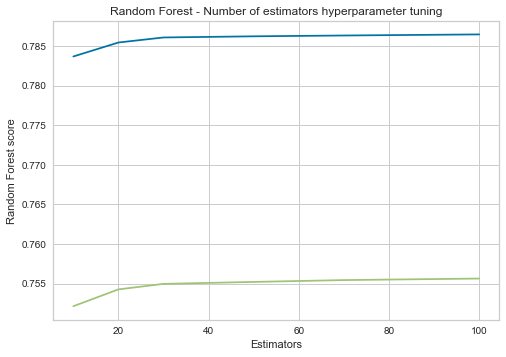

In [117]:
#rf_estimators_scores_X_train_avg = scores_X_train_avg
#rf_estimators_scores_X_test_avg = scores_X_test_avg
plt.plot(nb_estimators, list(rf_estimators_scores_X_train_avg.values()))
plt.plot(nb_estimators, list(rf_estimators_scores_X_test_avg.values()))
plt.xlabel('Estimators')
plt.ylabel('Random Forest score')
plt.title('Random Forest - Number of estimators hyperparameter tuning')
plt.show()

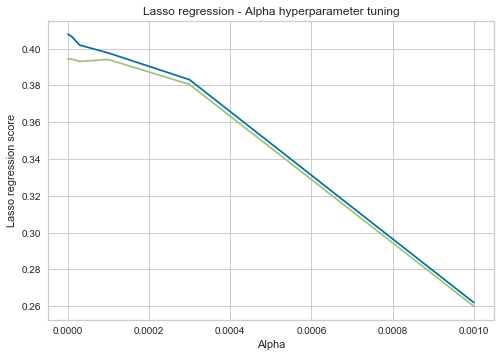

In [118]:
#lasso_scores_X_train_avg = scores_X_train_avg
#lasso_scores_X_test_avg = scores_X_test_avg
plt.plot(lasso_alphas, list(lasso_scores_X_train_avg.values()))
plt.plot(lasso_alphas, list(lasso_scores_X_test_avg.values()))
plt.xlabel('Alpha')
plt.ylabel('Lasso regression score')
plt.title('Lasso regression - Alpha hyperparameter tuning')
plt.show()

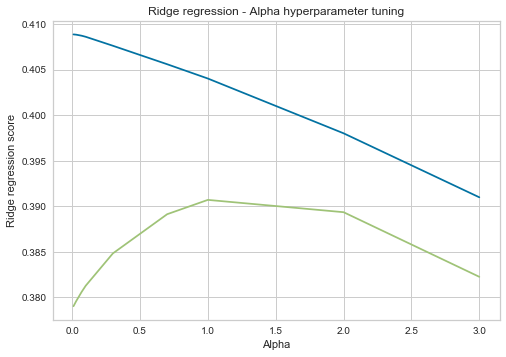

In [119]:
#ridge_scores_X_train_avg = scores_X_train_avg
#ridge_scores_X_test_avg = scores_X_test_avg
plt.plot(ridge_alphas, list(ridge_scores_X_train_avg.values()))
plt.plot(ridge_alphas, list(ridge_scores_X_test_avg.values()))
plt.xlabel('Alpha')
plt.ylabel('Ridge regression score')
plt.title('Ridge regression - Alpha hyperparameter tuning')
plt.show()

#### GridSearchCV

In [ ]:
params = {'alpha': np.linspace(0, 2, 10)} # TDict of the hyperparameters we want to optimize
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=params, n_jobs=1, scoring='r2')
grid_result=grid.fit(X_train, y_train)

print('Best model has', grid_result.best_score_, 'r2 using', grid_result.best_params_)

In [ ]:
params = {'max_depth': np.linspace(0, 2, 10) ; 'n_estimators': np.linspace()} # TDict of the hyperparameters we want to optimize
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=params, n_jobs=1, scoring='r2')
grid_result=grid.fit(X_train, y_train)

print('Best model has', grid_result.best_score_, 'r2 using', grid_result.best_params_)